# Credit Card Customer Segmentation via Cluster Analysis
Personalization can give better results for customer retention

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3
plt.style.use('seaborn-white')
sns.set_style('white')

# Explanation of 18 Behavioral Variables
- **CUST_ID** : Identification of Credit Card holder
- **BALANCE** : Balance amount left in their account to make purchases
- **BALANCE_FREQUENCY** : How frequently the balance is updated, score between 0 and 1 
    - 1 - frequently updated
    - 0 - not frequently updated
- **PURCHASES** : Amount of purchases made from account
- **ONEOFF** : Maximum purchase amount done in one-go
- **INSTALLMENTS** : Amount of purchase done in installment
- **CASH_ADVANCE** : Cash in advance given by the user
- **PURCHASES_FREQUENCY** : How frequently the Purchases are being made, score between 0 and 1 
    - 1 - frequently purchased
    - 0 - not frequently purchased
- **ONEOFF_FREQUENCY** : How frequently Purchases are happening in one-go 
    - 1 - frequently purchased
    - 0 - not frequently purchased
- **INSTALLMENTS_FREQUENCY** : How frequently Purchases in installments are being done
    - 1 - frequently purchased
    - 0 - not frequently purchased
- **CASHADVANCE_FREQUENCY** : How frequently the cash in advance being paid
- **CASHADVANCE_TRX** : Number of Transactions made with "Cash in Advanced"
- **PURCHASES_TRX** : Numbe of purchase transactions made
- **CREDIT_LIMIT** : Limit of Credit Card for user
- **PAYMENTS** : Amount of Payment done by user
- **MINIMUM_PAYMENTS** : Minimum amount of payments made by user
- **PRC_FULL_PAYMENT** : Percent of full payment paid by user
- **TENURE** : Tenure of credit card service for user

## Load dataset
https://www.kaggle.com/arjunbhasin2013/ccdata

In [3]:
credit_card = pd.read_csv('credit_card.csv')
credit_card = credit_card.rename(columns={
    'ONEOFF_PURCHASES': 'ONEOFF',
    'INSTALLMENTS_PURCHASES': 'INSTALLMENTS',
    'ONEOFF_PURCHASES_FREQUENCY': 'ONEOFF_FREQUENCY',
    'PURCHASES_INSTALLMENTS_FREQUENCY': 'INSTALLMENTS_FREQUENCY'
})

In [4]:
credit_card.head()

CUST_ID   BALANCE  BALANCE_FREQUENCY  PURCHASES   ONEOFF  INSTALLMENTS  \
0  C10001    40.901              0.818      95.40     0.00          95.4   
1  C10002  3202.467              0.909       0.00     0.00           0.0   
2  C10003  2495.149              1.000     773.17   773.17           0.0   
3  C10004  1666.671              0.636    1499.00  1499.00           0.0   
4  C10005   817.714              1.000      16.00    16.00           0.0   

   CASH_ADVANCE  PURCHASES_FREQUENCY  ONEOFF_FREQUENCY  \
0         0.000                0.167             0.000   
1      6442.945                0.000             0.000   
2         0.000                1.000             1.000   
3       205.788                0.083             0.083   
4         0.000                0.083             0.083   

   INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
0                   0.083                   0.000                 0   
1                   0.000                   0.250                 4   
2                   0.000                   0.000                 0   
3                   0.000                   0.083                 1   
4                   0.000                   0.000                 0   

   PURCHASES_TRX  CREDIT_LIMIT  PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  \
0              2        1000.0   201.802           139.510             0.000   
1              0        7000.0  4103.033          1072.340             0.222   
2             12        7500.0   622.067           627.285             0.000   
3              1        7500.0     0.000               NaN             0.000   
4              1        1200.0   678.335           244.791             0.000   

   TENURE  
0      12  
1      12  
2      12  
3      12  
4      12

In [5]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CUST_ID                 8950 non-null   object 
 1   BALANCE                 8950 non-null   float64
 2   BALANCE_FREQUENCY       8950 non-null   float64
 3   PURCHASES               8950 non-null   float64
 4   ONEOFF                  8950 non-null   float64
 5   INSTALLMENTS            8950 non-null   float64
 6   CASH_ADVANCE            8950 non-null   float64
 7   PURCHASES_FREQUENCY     8950 non-null   float64
 8   ONEOFF_FREQUENCY        8950 non-null   float64
 9   INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY  8950 non-null   float64
 11  CASH_ADVANCE_TRX        8950 non-null   int64  
 12  PURCHASES_TRX           8950 non-null   int64  
 13  CREDIT_LIMIT            8949 non-null   float64
 14  PAYMENTS                8950 non-null   

# Data Preprocessing
1. Drop `CUST_ID` karena ID tidak ada hubungannya dengan segmentasi user
2. Drop missing values for `CREDIT_LIMIT` column karena hanya terdapat 1 data saja yang hilang
3. Impute missing values in `MINIMUM_PAYMENTS` with `PAYMENTS` value

In [6]:
credit_card = credit_card.drop('CUST_ID', axis=1).copy()

In [7]:
# There are 313 missing values on MINIMUM_PAYMENTS and 1 missing value on CREDIT_LIMIT`
credit_card.isna().sum()

BALANCE                     0
BALANCE_FREQUENCY           0
PURCHASES                   0
ONEOFF                      0
INSTALLMENTS                0
CASH_ADVANCE                0
PURCHASES_FREQUENCY         0
ONEOFF_FREQUENCY            0
INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY      0
CASH_ADVANCE_TRX            0
PURCHASES_TRX               0
CREDIT_LIMIT                1
PAYMENTS                    0
MINIMUM_PAYMENTS          313
PRC_FULL_PAYMENT            0
TENURE                      0
dtype: int64

In [8]:
# Fill MINIMUM_PAYMENTS missing values with their corresponding PAYMENTS values
def fillna_minimum_payments(df):
    if np.isnan(df['MINIMUM_PAYMENTS']):
        return df['PAYMENTS']
    else:
        return df['MINIMUM_PAYMENTS']

credit_card.dropna(subset=['CREDIT_LIMIT'], inplace=True)
credit_card['MINIMUM_PAYMENTS'] = credit_card.apply(lambda x: fillna_minimum_payments(x), axis=1)

In [9]:
credit_card.isna().sum()

BALANCE                   0
BALANCE_FREQUENCY         0
PURCHASES                 0
ONEOFF                    0
INSTALLMENTS              0
CASH_ADVANCE              0
PURCHASES_FREQUENCY       0
ONEOFF_FREQUENCY          0
INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY    0
CASH_ADVANCE_TRX          0
PURCHASES_TRX             0
CREDIT_LIMIT              0
PAYMENTS                  0
MINIMUM_PAYMENTS          0
PRC_FULL_PAYMENT          0
TENURE                    0
dtype: int64

# Exploratory Data Analysis

In [10]:
credit_card.describe().transpose()

count      mean       std   min       25%       50%  \
BALANCE                 8949.0  1564.648  2081.584   0.0   128.366   873.680   
BALANCE_FREQUENCY       8949.0     0.877     0.237   0.0     0.889     1.000   
PURCHASES               8949.0  1003.317  2136.728   0.0    39.800   361.490   
ONEOFF                  8949.0   592.504  1659.969   0.0     0.000    38.000   
INSTALLMENTS            8949.0   411.114   904.378   0.0     0.000    89.000   
CASH_ADVANCE            8949.0   978.960  2097.264   0.0     0.000     0.000   
PURCHASES_FREQUENCY     8949.0     0.490     0.401   0.0     0.083     0.500   
ONEOFF_FREQUENCY        8949.0     0.202     0.298   0.0     0.000     0.083   
INSTALLMENTS_FREQUENCY  8949.0     0.364     0.397   0.0     0.000     0.167   
CASH_ADVANCE_FREQUENCY  8949.0     0.135     0.200   0.0     0.000     0.000   
CASH_ADVANCE_TRX        8949.0     3.249     6.825   0.0     0.000     0.000   
PURCHASES_TRX           8949.0    14.711    24.859   0.0     1.000     7.000   
CREDIT_LIMIT            8949.0  4494.449  3638.816  50.0  1600.000  3000.000   
PAYMENTS                8949.0  1733.337  2895.168   0.0   383.283   857.063   
MINIMUM_PAYMENTS        8949.0   845.347  2362.433   0.0   164.391   295.779   
PRC_FULL_PAYMENT        8949.0     0.154     0.293   0.0     0.000     0.000   
TENURE                  8949.0    11.518     1.337   6.0    12.000    12.000   

                             75%        max  
BALANCE                 2054.373  19043.139  
BALANCE_FREQUENCY          1.000      1.000  
PURCHASES               1110.170  49039.570  
ONEOFF                   577.830  40761.250  
INSTALLMENTS             468.650  22500.000  
CASH_ADVANCE            1113.869  47137.212  
PURCHASES_FREQUENCY        0.917      1.000  
ONEOFF_FREQUENCY           0.300      1.000  
INSTALLMENTS_FREQUENCY     0.750      1.000  
CASH_ADVANCE_FREQUENCY     0.222      1.500  
CASH_ADVANCE_TRX           4.000    123.000  
PURCHASES_TRX             17.000    358.000  
CREDIT_LIMIT            6500.000  30000.000  
PAYMENTS                1901.279  50721.483  
MINIMUM_PAYMENTS         794.656  76406.208  
PRC_FULL_PAYMENT           0.143      1.000  
TENURE                    12.000     12.000

1. Secara umum, seluruh data memiliki right skewed distribution karena banyaknya nilai outlier yang bernilai besar
2. Banyak user yang memiliki `BALANCE` mendekati 0. Users ini bisa dianggap pengguna aktif karena saldonya hampir habis digunakan
3. Tidak banyak user yang dapat membayar tagihan kartu kreditnya secara full

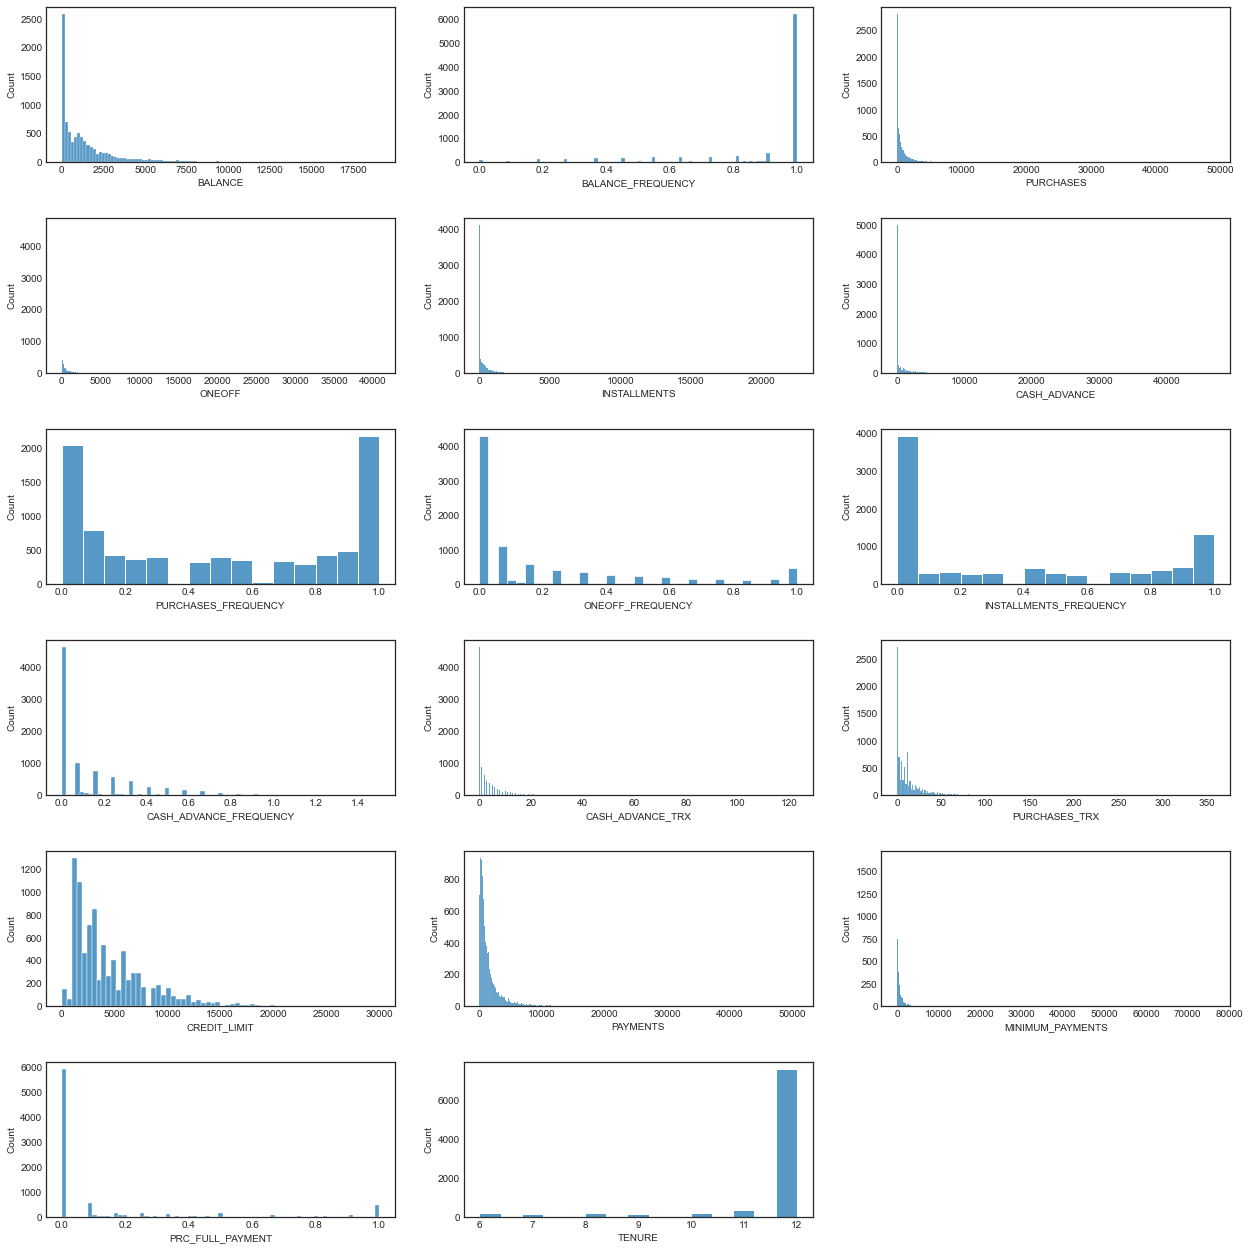

In [11]:
fig, axes = plt.subplots(6, 3, figsize=(18, 18))
for cols, ax in zip(credit_card.columns, axes.flatten()):
    sns.histplot(ax=ax, data=credit_card, x=cols)
plt.gca().axis('off')
plt.tight_layout(pad=3)

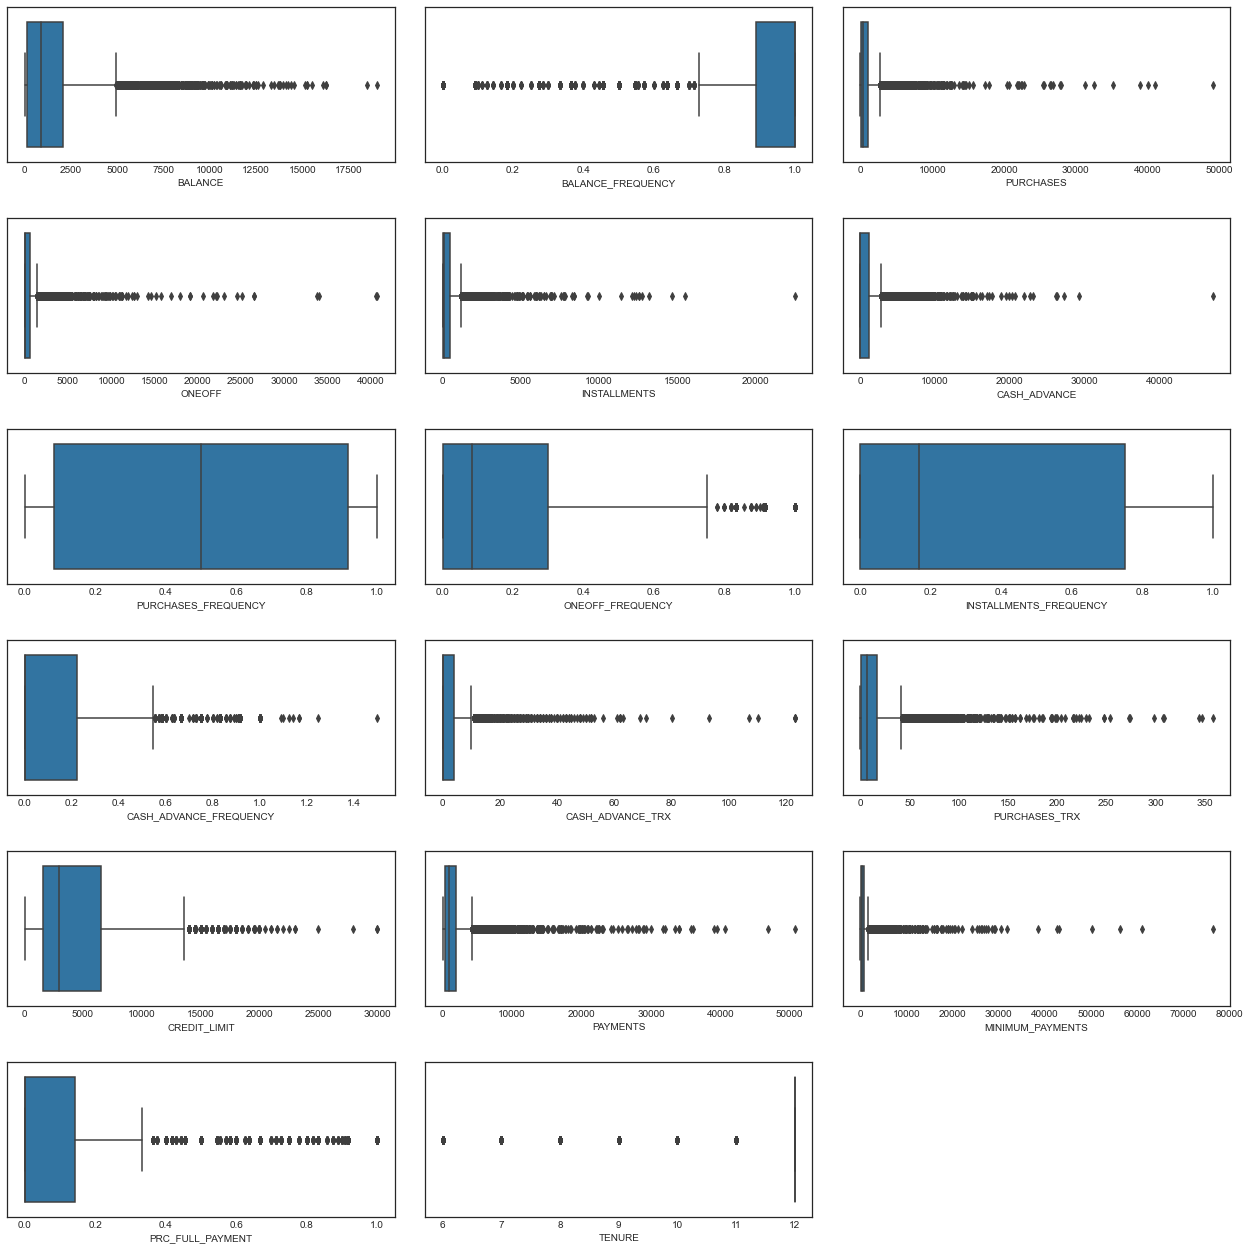

In [12]:
fig, axes = plt.subplots(6, 3, figsize=(18, 18))
for cols, ax in zip(credit_card.columns, axes.flatten()):
    sns.boxplot(ax=ax, data=credit_card, x=cols)
plt.gca().axis('off')
plt.tight_layout(pad=3)

1. `PURCHASES` memiliki korelasi positif yang kuat dengan `PURCHASES_FREQUENCY`, `PURCHASES_TRX`, `ONEOFF`, `INSTALLMENTS`, `ONEOFF_FREQUENCY`, dan `INSTALLMENTS_FREQUENCY`. Besarnya pembelian yang dilakukan oleh credit card user dipengaruhi oleh jumlah transaksi dan frekuensinya. Nilai `PURCHASES` merupakan penjumlahan pembelian yang dilakukan baik secara `ONEOFF` maupun `INSTALLMENTS` sehingga ketiga variabel tersebut memiliki korelasi positif yang kuat.
2. `CASH_ADVANCE` memiliki korelasi positif yang kuat dengan `CASH_ADVANCE_FREQUENCY` dan `CASH_ADVANCE_TRX`. Besarnya pembelian yang dilakukan oleh credit card user dipengaruhi oleh jumlah transaksi dan frekuensinya.

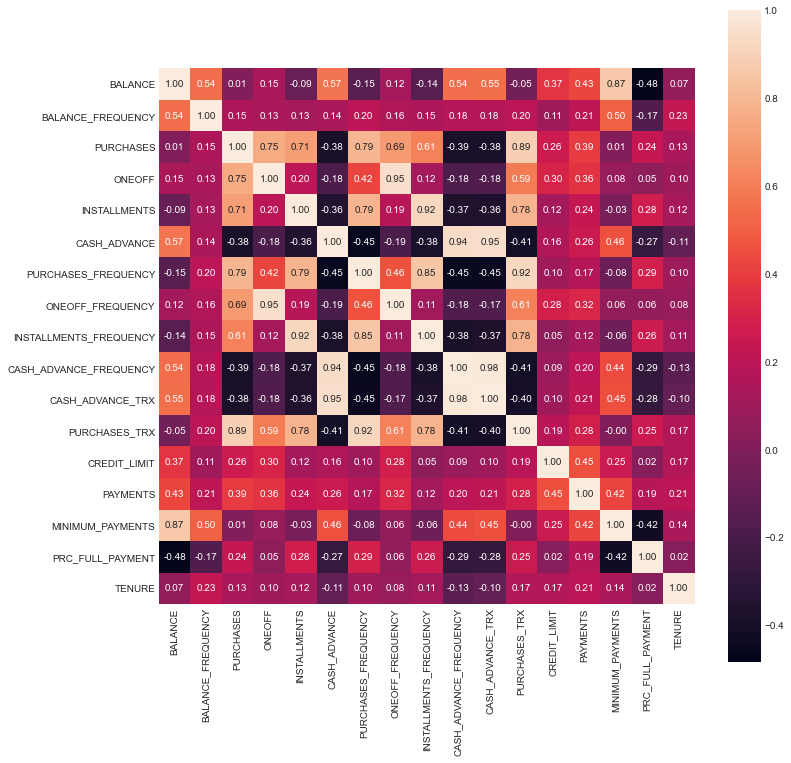

In [13]:
plt.figure(figsize=(12, 12))
corr_matrix = credit_card.corr(method='spearman')
sns.heatmap(corr_matrix, annot=corr_matrix, square=True, fmt='.2f');

# Clustering Algorithms Model Selection
## Clustering Algorithms
- k-Means
- Agglomerative
- Gaussian Mixture Models (GMM)

## Evaluation Metrics
- WCSS (Within-Cluster Sum of Square) - only for k-Means algorithm
- Silhouette Score - for all clustering algorithm

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

# Generate
def kmeans_cluster(X, n_clusters, random_state, wcss=False): 
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(X)
    X_cluster = X.copy()
    X_cluster['CLUSTER'] = kmeans.labels_
    X_cluster['CLUSTER'] = X_cluster['CLUSTER'].astype('category')
    if wcss == True:
        wcss_score = kmeans.inertia_
        return X_cluster, wcss_score
    return X_cluster

# Generate wcss and silhouette score for each k-Means clustering results start until stop
def kmeans_eval(X, start, stop, random_state):
    wcss = []
    silhouette = []
    membership = []
    for n in range(start, stop):
        X_cluster, wcss_score = kmeans_cluster(X, n, random_state, wcss=True)
        wcss.append(wcss_score)
        silhouette.append(silhouette_score(X, X_cluster['CLUSTER']))
        membership.append(dict(X_cluster['CLUSTER'].value_counts().sort_index()))
    evaluation = pd.DataFrame({
        'n_clusters': range(start, stop),
        'wcss': wcss,
        'silhouette': silhouette,
        'membership': membership
    })
    return evaluation

def agglo_cluster(X, n_clusters, linkage):
    agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    agglo.fit(X)
    X_cluster = X.copy()
    X_cluster['CLUSTER'] = agglo.labels_
    X_cluster['CLUSTER'] = X_cluster['CLUSTER'].astype('category')
    return X_cluster

# Generate silhouette score for each Agglomerative clustering results with all linkage options (single, complete, average, ward)
def agglo_eval(X, start, stop):
    linkages = ['single', 'complete', 'average', 'ward']
    evaluation = pd.DataFrame(columns=pd.MultiIndex.from_product([linkages, ['n_clusters', 'silhouette', 'membership']]))
    i = 0
    for linkage in linkages:
        silhouette = []
        membership = []
        for n in range(start, stop):
            X_cluster = agglo_cluster(X, n, linkage)
            silhouette.append(silhouette_score(X, X_cluster['CLUSTER']))
            membership.append(dict(X_cluster['CLUSTER'].value_counts().sort_index()))
        evaluation.iloc[:, i] = range(start, stop)
        evaluation.iloc[:, i+1] = silhouette
        evaluation.iloc[:, i+2] = membership
        i += 3
    return evaluation

def gmm_cluster(X, n_components, covariance, random_state):
    gmm = GaussianMixture(
        n_components=n_components, 
        covariance_type = covariance,
        random_state=random_state
    )
    gmm.fit(X)
    X_cluster = X.copy()
    X_cluster['CLUSTER'] = gmm.predict(X)
    X_cluster['CLUSTER'] = X_cluster['CLUSTER'].astype('category')
    return X_cluster

# Generate silhouette score for each GMM clustering results with all covariance_type options (full, tied, diag, spherical)
def gmm_eval(X, start, stop, random_state):
    covariances = ['full', 'tied', 'diag', 'spherical']
    evaluation = pd.DataFrame(columns=pd.MultiIndex.from_product([covariances, ['n_clusters', 'silhouette', 'membership']]))
    i = 0
    for covariance in covariances:
        silhouette = []
        membership = []
        for n in range(start, stop):
            X_cluster = gmm_cluster(X, n, covariance, random_state)
            silhouette.append(silhouette_score(X, X_cluster['CLUSTER']))
            membership.append(dict(X_cluster['CLUSTER'].value_counts().sort_index()))
        evaluation.iloc[:, i] = range(start, stop)
        evaluation.iloc[:, i+1] = silhouette
        evaluation.iloc[:, i+2] = membership
        i += 3
    return evaluation

# Generate lineplot for selecting the optimum number of clusters with elbow method 
def plot_elbow(evaluation, silhouette=False):
    if silhouette == True:
        fig, ax = plt.subplots(1, 2, figsize=(16, 4))
        ax[0].title.set_text('Elbow Method')
        ax[1].title.set_text('Silhouette Score')
        sns.lineplot(ax=ax[0], data=evaluation, x='n_clusters', y='wcss', marker='o', markersize=8)
        sns.lineplot(ax=ax[1], data=evaluation, x='n_clusters', y='silhouette', marker='o', markersize=8)
    else:
        plt.figure(figsize=(8, 4))
        sns.lineplot(data=evaluation, x='n_clusters', y='wcss', marker='o', markerfacecolor='tab:red', markersize=8)
    plt.xticks(ticks=evaluation['n_clusters'], labels=evaluation['n_clusters'])

# Generate lineplot for selecting the optimum number of clusters based on silhouette score
def plot_silhouette(evaluation, multiple=False):
    plt.figure(figsize=(8, 4))
    if multiple == True:
        labels = []
        for column in evaluation.columns:
            if column[1] == 'silhouette':
                sns.lineplot(x=evaluation.iloc[:, 0], y=evaluation[column], marker='o', markersize=8)
                labels.append(column[0])
        plt.legend(labels, loc=[1.05, 0.35])
    else:
        sns.lineplot(data=evaluation, x='n_clusters', y='silhouette', marker='o', markersize=8)

    plt.title('Silhouette Score')
    plt.xlabel('n_clusters')
    plt.ylabel('silhoutte')
    plt.xticks(ticks=evaluation.iloc[:, 0], labels=evaluation.iloc[:, 0])

# Generate scatterplot based on general clustering results
def plot_scatter(X, selected_cols, clustering, width=1000, height=750):
    fig = px.scatter_matrix(
        data_frame=X, 
        dimensions=selected_cols, 
        color='CLUSTER',
        labels={col:col.replace('_', ' ') for col in selected_cols}
    )
    fig.update_layout(
        template='ggplot2',
        title_text=f'Scatter Matrix of {clustering} Clustering Result',
        title_font_size=24,
        width=width,
        height=height
    )
    fig.show()

# Generate violinplot based on general clustering results
def plot_violin(X, row, column, length, width):
    fig, axes = plt.subplots(row, column, figsize=(length, width))
    for cols, ax in zip(X.select_dtypes('number').columns, axes.ravel()):
        sns.violinplot(data=X, x='CLUSTER', y=cols, palette='Set1', cut=0, ax=ax)
    plt.tight_layout(pad=2)

# Generate dendogram for Agglomerative clustering results
def plot_dendogram(X, **kwargs):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    linkages = ['single', 'complete', 'average', 'ward']
    for linkage, ax in zip(linkages, axes.flatten()):
        # Create the agglomerative model
        model = AgglomerativeClustering(n_clusters=None, linkage=linkage, distance_threshold=0)
        model.fit(X)
        # Create the counts of samples under each node
        counts = np.zeros(model.children_.shape[0])
        n_samples = len(model.labels_)
        for i, merge in enumerate(model.children_):
            current_count = 0
            for child_index in merge:
                if child_index < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_index - n_samples]
            counts[i] = current_count

        linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
        # Plot the corresponding dendrogram
        ax.title.set_text(f'{linkage.title()} Linkage Clustering Dendrogram')
        dendrogram(linkage_matrix, **kwargs, ax=ax)
    plt.tight_layout(pad=3)

## Features Selection
1. Cluster the dataset using all features and evaluate the results of the clustering for each cluster algorithm
2. Select the optimal number of cluster for each cluster algorithm
3. Create a new dataset by adding the clustering result to the initial dataset
4. Split dataset into train and test by using clustering results column as a targets or labels
5. Train a classification machine learning model that has a feature_importances attribute (decision trees and random forest) with the train set
6. Predict the test set labels outcome with the selected classification machine learning model and make sure it has good evaluation score
7. Generate the feature_importances from the model and analyze it for each cluster algorithm

In [16]:
fselect_kmeans = kmeans_eval(credit_card, 2, 7, random_state=0)
fselect_kmeans

n_clusters       wcss  silhouette  \
0           2  2.805e+11       0.512   
1           3  2.339e+11       0.466   
2           4  2.074e+11       0.466   
3           5  1.824e+11       0.397   
4           6  1.638e+11       0.389   

                                         membership  
0                                {0: 1924, 1: 7025}  
1                        {0: 2295, 1: 6520, 2: 134}  
2                 {0: 6439, 1: 2320, 2: 132, 3: 58}  
3          {0: 2570, 1: 5640, 2: 25, 3: 673, 4: 41}  
4  {0: 537, 1: 5515, 2: 26, 3: 450, 4: 2363, 5: 58}

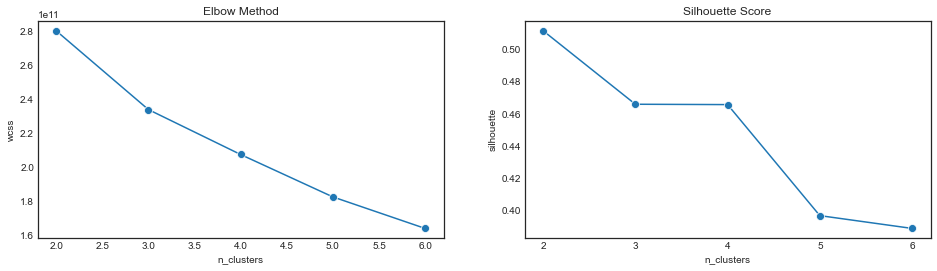

In [17]:
plot_elbow(fselect_kmeans, silhouette=True)

In [18]:
fselect_agglo = agglo_eval(credit_card, 2, 7)
fselect_agglo

single                                                       complete  \
  n_clusters silhouette                               membership n_clusters   
0          2      0.874                          {0: 8948, 1: 1}          2   
1          3      0.825                    {0: 8947, 1: 1, 2: 1}          3   
2          4      0.825              {0: 8946, 1: 1, 2: 1, 3: 1}          4   
3          5      0.825        {0: 8945, 1: 1, 2: 1, 3: 1, 4: 1}          5   
4          6      0.825  {0: 8944, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}          6   

                                                           average             \
  silhouette                                 membership n_clusters silhouette   
0      0.813                           {0: 8928, 1: 21}          2      0.909   
1      0.816                    {0: 8906, 1: 21, 2: 22}          3      0.885   
2      0.815              {0: 21, 1: 8905, 2: 22, 3: 1}          4      0.854   
3      0.782        {0: 22, 1: 8905, 2: 17, 3: 1, 4: 4}          5      0.845   
4      0.782  {0: 8905, 1: 20, 2: 17, 3: 1, 4: 4, 5: 2}          6      0.805   

                                                   ward             \
                                  membership n_clusters silhouette   
0                            {0: 8948, 1: 1}          2      0.370   
1                      {0: 8947, 1: 1, 2: 1}          3      0.375   
2               {0: 22, 1: 8925, 2: 1, 3: 1}          4      0.343   
3         {0: 8925, 1: 20, 2: 1, 3: 1, 4: 2}          5      0.358   
4  {0: 21, 1: 20, 2: 8904, 3: 1, 4: 2, 5: 1}          6      0.368   

                                                     
                                         membership  
0                                {0: 3580, 1: 5369}  
1                         {0: 3557, 1: 5369, 2: 23}  
2                {0: 5369, 1: 1038, 2: 23, 3: 2519}  
3         {0: 1038, 1: 2519, 2: 23, 3: 95, 4: 5274}  
4  {0: 668, 1: 2519, 2: 370, 3: 95, 4: 5274, 5: 23}

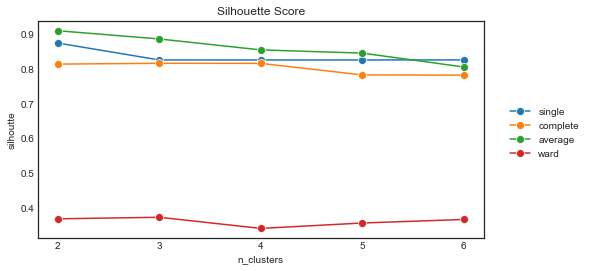

In [19]:
plot_silhouette(fselect_agglo, multiple=True)

In [20]:
fselect_gmm = gmm_eval(credit_card, 2, 7, random_state=0)
fselect_gmm

full                                                                   \
  n_clusters silhouette                                            membership   
0          2      0.485                                    {0: 7749, 1: 1200}   
1          3      0.067                            {0: 3703, 1: 644, 2: 4602}   
2          4     -0.172                   {0: 2614, 1: 483, 2: 1919, 3: 3933}   
3          5     -0.167           {0: 2004, 1: 1641, 2: 915, 3: 3939, 4: 450}   
4          6     -0.181  {0: 2299, 1: 1188, 2: 756, 3: 2611, 4: 267, 5: 1828}   

        tied                                                              \
  n_clusters silhouette                                       membership   
0          2      0.518                                {0: 8164, 1: 785}   
1          3      0.508                         {0: 8118, 1: 740, 2: 91}   
2          4      0.316                 {0: 7882, 1: 824, 2: 219, 3: 24}   
3          5      0.333         {0: 7465, 1: 558, 2: 126, 3: 21, 4: 779}   
4          6      0.339  {0: 562, 1: 47, 2: 122, 3: 22, 4: 777, 5: 7419}   

        diag                                                                  \
  n_clusters silhouette                                           membership   
0          2      0.314                                   {0: 5692, 1: 3257}   
1          3      0.023                          {0: 4344, 1: 2342, 2: 2263}   
2          4      0.011                 {0: 2031, 1: 3847, 2: 1217, 3: 1854}   
3          5     -0.037         {0: 2030, 1: 1250, 2: 1155, 3: 665, 4: 3849}   
4          6     -0.035  {0: 2024, 1: 1371, 2: 327, 3: 525, 4: 4091, 5: 611}   

   spherical                                                                    
  n_clusters silhouette                                             membership  
0          2      0.359                                     {0: 5072, 1: 3877}  
1          3      0.225                            {0: 3523, 1: 3888, 2: 1538}  
2          4      0.113                    {0: 2304, 1: 2886, 2: 2768, 3: 991}  
3          5      0.101            {0: 2116, 1: 981, 2: 2368, 3: 659, 4: 2825}  
4          6      0.065  {0: 2239, 1: 1961, 2: 1678, 3: 638, 4: 1130, 5: 1303}

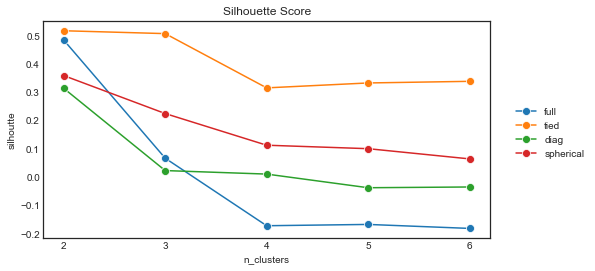

In [21]:
plot_silhouette(fselect_gmm, multiple=True)

In [22]:
X_fselect_kmeans = kmeans_cluster(credit_card, 4, random_state=0)
X_fselect_agglo = agglo_cluster(credit_card, 3, 'ward')
X_fselect_gmm = gmm_cluster(credit_card, 3, 'tied', random_state=0)

In [23]:
from sklearn.model_selection import train_test_split

X = X_fselect_kmeans.drop('CLUSTER', axis=1)
y = X_fselect_kmeans['CLUSTER']
X_kmeans_train, X_kmeans_test, y_kmeans_train, y_kmeans_test = train_test_split(X, y, stratify=y, random_state=0)

X = X_fselect_agglo.drop('CLUSTER', axis=1)
y = X_fselect_agglo['CLUSTER']
X_agglo_train, X_agglo_test, y_agglo_train, y_agglo_test = train_test_split(X, y, stratify=y, random_state=0)

X = X_fselect_gmm.drop('CLUSTER', axis=1)
y = X_fselect_gmm['CLUSTER']
X_gmm_train, X_gmm_test, y_gmm_train, y_gmm_test = train_test_split(X, y, stratify=y, random_state=0)

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

tree_kmeans = DecisionTreeClassifier(
    min_samples_split=5,
    min_samples_leaf=2,
).fit(X_kmeans_train, y_kmeans_train)

tree_agglo = DecisionTreeClassifier(
    min_samples_split=5,
    min_samples_leaf=2,
).fit(X_agglo_train, y_agglo_train)

tree_gmm = DecisionTreeClassifier(
    min_samples_split=5,
    min_samples_leaf=2,
).fit(X_gmm_train, y_gmm_train)

In [25]:
print(classification_report(y_kmeans_train, tree_kmeans.predict(X_kmeans_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4829
           1       0.99      0.99      0.99      1740
           2       0.99      0.97      0.98        99
           3       1.00      0.86      0.92        43

    accuracy                           1.00      6711
   macro avg       0.99      0.95      0.97      6711
weighted avg       1.00      1.00      1.00      6711



In [26]:
print(classification_report(y_kmeans_test, tree_kmeans.predict(X_kmeans_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1610
           1       0.97      0.95      0.96       580
           2       0.93      0.85      0.89        33
           3       1.00      0.73      0.85        15

    accuracy                           0.98      2238
   macro avg       0.97      0.88      0.92      2238
weighted avg       0.98      0.98      0.98      2238



In [27]:
print(classification_report(y_agglo_test, tree_agglo.predict(X_agglo_test)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       889
           1       0.98      0.97      0.97      1343
           2       0.56      0.83      0.67         6

    accuracy                           0.97      2238
   macro avg       0.83      0.92      0.87      2238
weighted avg       0.97      0.97      0.97      2238



In [28]:
print(classification_report(y_gmm_test, tree_gmm.predict(X_gmm_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2030
           1       0.93      0.93      0.93       185
           2       0.78      0.78      0.78        23

    accuracy                           0.99      2238
   macro avg       0.90      0.90      0.90      2238
weighted avg       0.99      0.99      0.99      2238



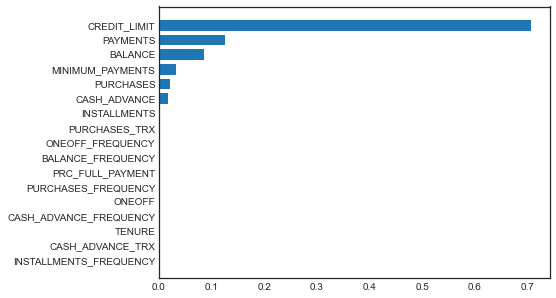

In [29]:
sorted_index = tree_kmeans.feature_importances_.argsort()
plt.figure(figsize=(7, 5))
plt.barh(X_kmeans_train.columns[sorted_index], tree_kmeans.feature_importances_[sorted_index]);

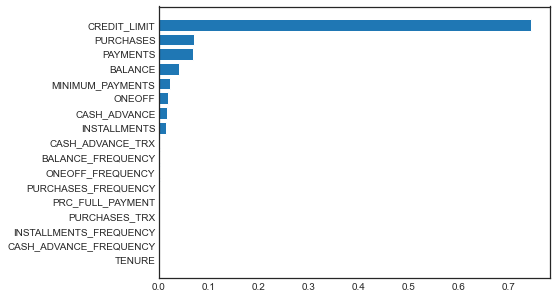

In [30]:
sorted_index = tree_agglo.feature_importances_.argsort()
plt.figure(figsize=(7, 5))
plt.barh(X_agglo_train.columns[sorted_index], tree_agglo.feature_importances_[sorted_index]);

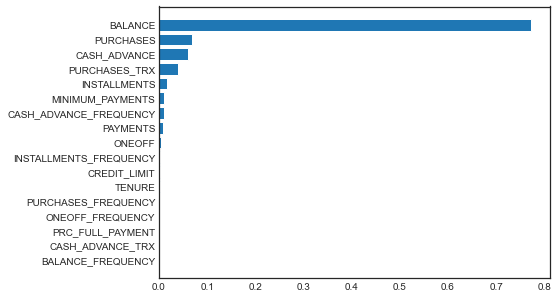

In [31]:
sorted_index = tree_gmm.feature_importances_.argsort()
plt.figure(figsize=(7, 5))
plt.barh(X_gmm_train.columns[sorted_index], tree_gmm.feature_importances_[sorted_index]);

In [32]:
rf_kmeans = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=2,
).fit(X_kmeans_train, y_kmeans_train)

rf_agglo = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=2,
).fit(X_agglo_train, y_agglo_train)

rf_gmm = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=2,
).fit(X_gmm_train, y_gmm_train)

In [33]:
print(classification_report(y_kmeans_test, rf_kmeans.predict(X_kmeans_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1610
           1       0.98      0.96      0.97       580
           2       1.00      0.82      0.90        33
           3       1.00      0.73      0.85        15

    accuracy                           0.98      2238
   macro avg       0.99      0.88      0.93      2238
weighted avg       0.98      0.98      0.98      2238



In [34]:
print(classification_report(y_agglo_test, rf_agglo.predict(X_agglo_test)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       889
           1       0.98      0.99      0.98      1343
           2       0.83      0.83      0.83         6

    accuracy                           0.98      2238
   macro avg       0.93      0.93      0.93      2238
weighted avg       0.98      0.98      0.98      2238



In [35]:
print(classification_report(y_gmm_test, rf_gmm.predict(X_gmm_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2030
           1       0.95      0.96      0.95       185
           2       0.91      0.91      0.91        23

    accuracy                           0.99      2238
   macro avg       0.95      0.95      0.95      2238
weighted avg       0.99      0.99      0.99      2238



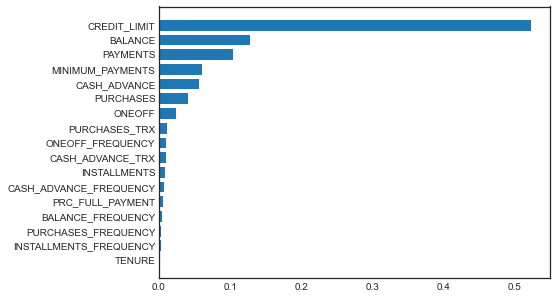

In [36]:
sorted_index = rf_kmeans.feature_importances_.argsort()
plt.figure(figsize=(7, 5))
plt.barh(X_kmeans_train.columns[sorted_index], rf_kmeans.feature_importances_[sorted_index]);

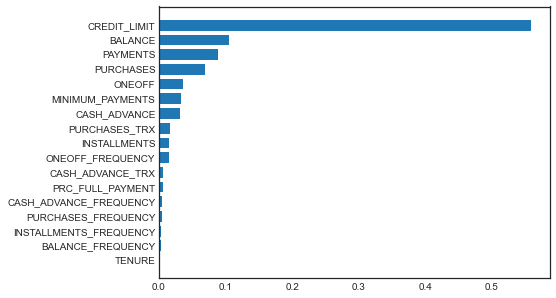

In [37]:
sorted_index = rf_agglo.feature_importances_.argsort()
plt.figure(figsize=(7, 5))
plt.barh(X_agglo_train.columns[sorted_index], rf_agglo.feature_importances_[sorted_index]);

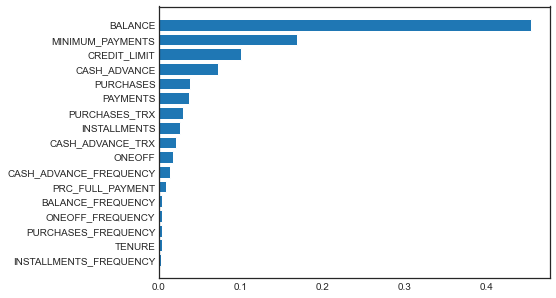

In [38]:
sorted_index = rf_gmm.feature_importances_.argsort()
plt.figure(figsize=(7, 5))
plt.barh(X_gmm_train.columns[sorted_index], rf_gmm.feature_importances_[sorted_index]);

In [39]:
selected_cols = ['BALANCE', 'CREDIT_LIMIT', 'PAYMENTS']
X_selected = credit_card[selected_cols]

Jika dilihat secara manual dengan violinplot bisa didapatkan 5-6 features. Dengan menggunakan machine learning tree model, hasilnya bisa digunakan untuk support hasil manualnya. 

# k-Means

In [40]:
kmeans_evaluation = kmeans_eval(X_selected, 2, 7, random_state=0)
kmeans_evaluation

n_clusters       wcss  silhouette  \
0           2  1.322e+11       0.548   
1           3  9.848e+10       0.519   
2           4  7.755e+10       0.448   
3           5  6.571e+10       0.463   
4           6  5.727e+10       0.453   

                                          membership  
0                                 {0: 2069, 1: 6880}  
1                         {0: 2462, 1: 6298, 2: 189}  
2                  {0: 2671, 1: 5276, 2: 905, 3: 97}  
3          {0: 5315, 1: 84, 2: 691, 3: 536, 4: 2323}  
4  {0: 5199, 1: 2223, 2: 430, 3: 511, 4: 85, 5: 501}

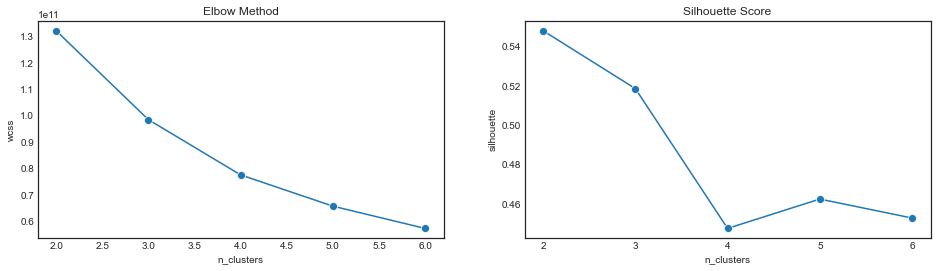

In [41]:
plot_elbow(kmeans_evaluation, silhouette=True)

In [42]:
X_kmeans = kmeans_cluster(X_selected, 3, random_state=0)
plot_scatter(X_kmeans, selected_cols, 'k-Means', 1000, 750)

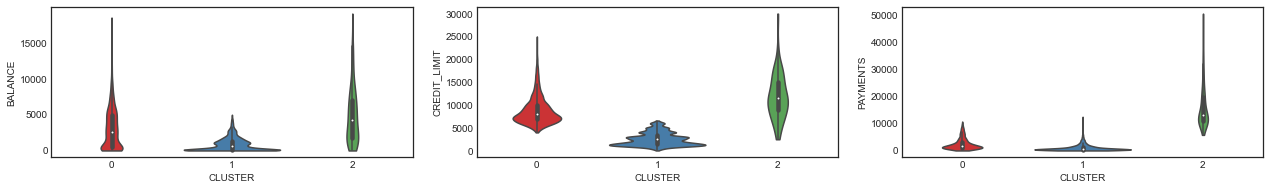

In [43]:
plot_violin(X_kmeans, 1, 3, 18, 3)

# Agglomerative
1. Single Linkage Clustering
2. Complete Linkage Clustering
3. Average Linkage Clustering
4. Ward Linkage Clustering

In [44]:
agglo_evaluation = agglo_eval(X_selected, 2, 7)
agglo_evaluation

single                                                       complete  \
  n_clusters silhouette                               membership n_clusters   
0          2      0.888                          {0: 8948, 1: 1}          2   
1          3      0.840                    {0: 8946, 1: 1, 2: 2}          3   
2          4      0.840              {0: 8945, 1: 1, 2: 2, 3: 1}          4   
3          5      0.840        {0: 8944, 1: 1, 2: 2, 3: 1, 4: 1}          5   
4          6      0.841  {0: 8941, 1: 1, 2: 3, 3: 1, 4: 1, 5: 2}          6   

                                                            average  \
  silhouette                                  membership n_clusters   
0      0.812                            {0: 8915, 1: 34}          2   
1      0.701                    {0: 34, 1: 123, 2: 8792}          3   
2      0.700             {0: 123, 1: 11, 2: 8792, 3: 23}          4   
3      0.673       {0: 11, 1: 23, 2: 8792, 3: 65, 4: 58}          5   
4      0.673  {0: 8792, 1: 23, 2: 9, 3: 65, 4: 58, 5: 2}          6   

                                                             ward             \
  silhouette                                membership n_clusters silhouette   
0      0.865                           {0: 8942, 1: 7}          2      0.559   
1      0.775                     {0: 8941, 1: 7, 2: 1}          3      0.546   
2      0.750              {0: 7, 1: 72, 2: 1, 3: 8869}          4      0.319   
3      0.750        {0: 5, 1: 72, 2: 1, 3: 8869, 4: 2}          5      0.330   
4      0.749  {0: 72, 1: 8869, 2: 1, 3: 4, 4: 2, 5: 1}          6      0.339   

                                                       
                                           membership  
0                                  {0: 1755, 1: 7194}  
1                          {0: 7194, 1: 1634, 2: 121}  
2                 {0: 1634, 1: 3418, 2: 121, 3: 3776}  
3         {0: 1209, 1: 3418, 2: 121, 3: 3776, 4: 425}  
4  {0: 718, 1: 3418, 2: 121, 3: 3776, 4: 425, 5: 491}

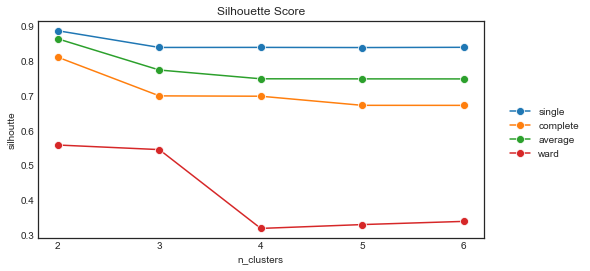

In [45]:
plot_silhouette(agglo_evaluation, multiple=True)

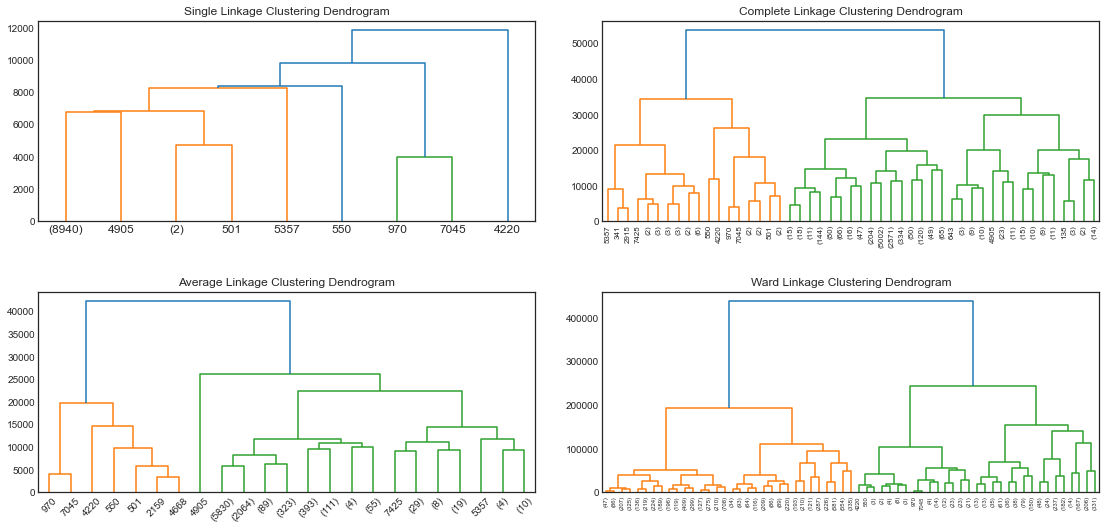

In [46]:
plot_dendogram(X_selected, truncate_mode='level', p=5)

In [47]:
X_agglo = agglo_cluster(X_selected, 3, 'ward')
plot_scatter(X_agglo, selected_cols, 'Ward Linkage', 1000, 750)

In [48]:
{low: 7194, medium: 1634, high: 121}

NameError: name 'low' is not defined

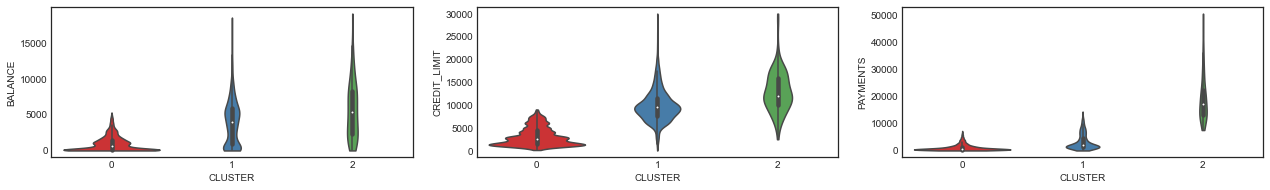

In [45]:
plot_violin(X_agglo, 1, 3, 18, 3)

# Gaussian Mixture Models (GMM)

In [39]:
gmm_evaluation = gmm_eval(X_selected, 2, 7, random_state=0)
gmm_evaluation

full             \
  n_clusters silhouette   
0          2      0.444   
1          3      0.294   
2          4      0.066   
3          5      0.051   
4          6      0.040   

                                                               tied  \
                                              membership n_clusters   
0                                     {0: 5954, 1: 2995}          2   
1                            {0: 3978, 1: 3899, 2: 1072}          3   
2                    {0: 2267, 1: 2324, 2: 3427, 3: 931}          4   
3           {0: 2080, 1: 1633, 2: 2333, 3: 2306, 4: 597}          5   
4  {0: 1590, 1: 1336, 2: 2052, 3: 1905, 4: 773, 5: 1293}          6   

                                                                      diag  \
  silhouette                                         membership n_clusters   
0      0.509                                  {0: 8112, 1: 837}          2   
1      0.508                          {0: 8069, 1: 778, 2: 102}          3   
2      0.518                   {0: 7533, 1: 570, 2: 749, 3: 97}          4   
3      0.533           {0: 7334, 1: 505, 2: 657, 3: 397, 4: 56}          5   
4      0.454  {0: 6469, 1: 1242, 2: 170, 3: 378, 4: 53, 5: 637}          6   

                                                                     \
  silhouette                                             membership   
0      0.457                                     {0: 6029, 1: 2920}   
1      0.311                            {0: 4003, 1: 3869, 2: 1077}   
2      0.207                    {0: 3035, 1: 3589, 2: 2026, 3: 299}   
3      0.224           {0: 3049, 1: 2192, 2: 1094, 3: 1875, 4: 739}   
4      0.099  {0: 1793, 1: 1320, 2: 1849, 3: 1807, 4: 812, 5: 1368}   

   spherical                                                                  
  n_clusters silhouette                                           membership  
0          2      0.436                                   {0: 5123, 1: 3826}  
1          3      0.366                          {0: 4136, 1: 3728, 2: 1085}  
2          4      0.335                  {0: 3827, 1: 3215, 2: 1712, 3: 195}  
3          5      0.345          {0: 3835, 1: 3222, 2: 1437, 3: 234, 4: 221}  
4          6      0.228  {0: 2382, 1: 2907, 2: 913, 3: 431, 4: 410, 5: 1906}

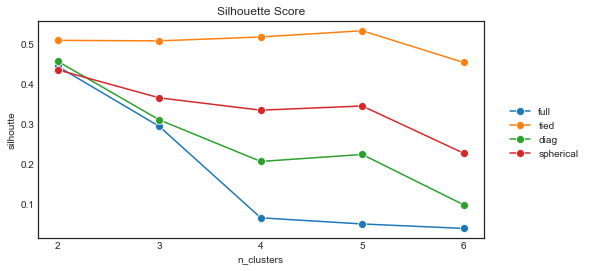

In [40]:
plot_silhouette(gmm_evaluation, multiple=True)

In [84]:
X_gmm = gmm_cluster(X_selected, 3, 'tied', random_state=0)
plot_scatter(X_gmm, selected_cols, 'GMM')

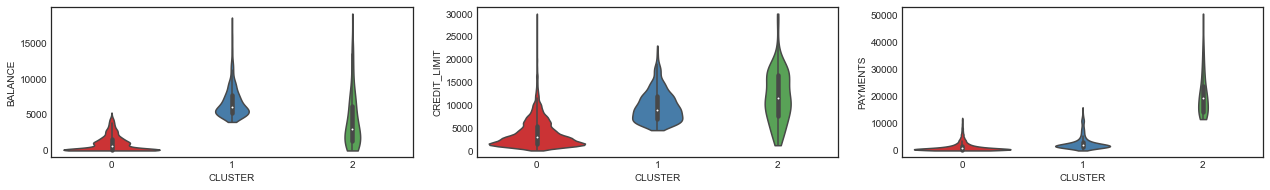

In [48]:
plot_violin(X_gmm, 1, 3, 18, 3)

# Visualize Clustering Result in 2D and 3D

In [49]:
from sklearn.decomposition import PCA

def plot_pca_2d(X_selected, X_cluster):
    pca = PCA(n_components=2)
    components = pca.fit_transform(X_selected)
    X_pca = pd.concat([pd.DataFrame(components), X_cluster['CLUSTER'].reset_index(drop=True)], axis=1)
    X_pca.rename(columns={0: 'PC1', 1: 'PC2'}, inplace=True)
    fig = px.scatter(
        X_pca, 
        x='PC1', y='PC2',
        color='CLUSTER'
    )
    fig.update_layout(
        template='ggplot2',
        title_text='PCA 2D Visualization',
        title_font_size=18,
        width=500, height=375
    )
    fig.show()

In [83]:
plot_pca_2d(X_selected, X_agglo)

In [74]:
fig = px.scatter_3d(
    data_frame=X_gmm,
    x='PAYMENTS', y='CREDIT_LIMIT', z='BALANCE',
    color='CLUSTER'
)
fig.update_layout(
    template='ggplot2',
    title_text='PCA 3D Visualization',
    title_font_size=18,
    width=600,
    height=400
)
fig.show()

ditambahkan lagi yang scatter matrix

In [77]:
credit_card_cluster = pd.concat([credit_card, X_agglo['CLUSTER']], axis=1)
credit_card_cluster.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES   ONEOFF  INSTALLMENTS  \
0    40.901              0.818      95.40     0.00          95.4   
1  3202.467              0.909       0.00     0.00           0.0   
2  2495.149              1.000     773.17   773.17           0.0   
3  1666.671              0.636    1499.00  1499.00           0.0   
4   817.714              1.000      16.00    16.00           0.0   

   CASH_ADVANCE  PURCHASES_FREQUENCY  ONEOFF_FREQUENCY  \
0         0.000                0.167             0.000   
1      6442.945                0.000             0.000   
2         0.000                1.000             1.000   
3       205.788                0.083             0.083   
4         0.000                0.083             0.083   

   INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
0                   0.083                   0.000                 0   
1                   0.000                   0.250                 4   
2                   0.000                   0.000                 0   
3                   0.000                   0.083                 1   
4                   0.000                   0.000                 0   

   PURCHASES_TRX  CREDIT_LIMIT  PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  \
0              2        1000.0   201.802           139.510             0.000   
1              0        7000.0  4103.033          1072.340             0.222   
2             12        7500.0   622.067           627.285             0.000   
3              1        7500.0     0.000             0.000             0.000   
4              1        1200.0   678.335           244.791             0.000   

   TENURE CLUSTER  
0      12       3  
1      12       1  
2      12       1  
3      12       1  
4      12       3

# Cluster Analysis
## Cluster 0 (Low Spender)
- Balance low
- Purchase, oneoff, installments, and their frequency relatively low (50% customers didn't purchase product using oneoff method)
- Credit limit low
- Payment low
## Cluster 1 (Medium Spender)
- Balance medium
- Purchase, oneoff, installments, and their frequency medium
- Credit limit medium
- Payment medium
## Cluster 2 (High Spender)
- Balance high
- Purchase, oneoff, installments, and their frequency relatively high 
- Credit limit high
- Payment high (percentage full payment is higher than the others)

In [100]:
credit_card_cluster.groupby('CLUSTER').median()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF  INSTALLMENTS  \
CLUSTER                                                                 
0         640.809                1.0    323.180    0.00         85.65   
1        3935.179                1.0    685.115  283.12         99.75   
2        5312.290                1.0   3419.920  989.14        432.56   

         CASH_ADVANCE  PURCHASES_FREQUENCY  ONEOFF_FREQUENCY  \
CLUSTER                                                        
0               0.000                0.455             0.000   
1            1026.907                0.500             0.167   
2            4799.004                0.833             0.250   

         INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
CLUSTER                                                                     
0                         0.167                   0.000                 0   
1                         0.167                   0.167                 2   
2                         0.417                   0.250                 5   

         PURCHASES_TRX  CREDIT_LIMIT   PAYMENTS  MINIMUM_PAYMENTS  \
CLUSTER                                                             
0                    7        2500.0    668.979           242.767   
1                   10        9500.0   2011.354          1095.110   
2                   25       12000.0  17068.967          1592.560   

         PRC_FULL_PAYMENT  TENURE  
CLUSTER                            
0                   0.000      12  
1                   0.000      12  
2                   0.091      12

In [101]:
credit_card_cluster.groupby('CLUSTER').min()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF  INSTALLMENTS  \
CLUSTER                                                                
0          0.000              0.000        0.0     0.0           0.0   
1          0.000              0.000        0.0     0.0           0.0   
2          4.383              0.091        0.0     0.0           0.0   

         CASH_ADVANCE  PURCHASES_FREQUENCY  ONEOFF_FREQUENCY  \
CLUSTER                                                        
0                 0.0                  0.0               0.0   
1                 0.0                  0.0               0.0   
2                 0.0                  0.0               0.0   

         INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
CLUSTER                                                                     
0                           0.0                     0.0                 0   
1                           0.0                     0.0                 0   
2                           0.0                     0.0                 0   

         PURCHASES_TRX  CREDIT_LIMIT  PAYMENTS  MINIMUM_PAYMENTS  \
CLUSTER                                                            
0                    0         150.0      0.00             0.000   
1                    0          50.0      0.00             0.000   
2                    0        2500.0   7566.47            19.492   

         PRC_FULL_PAYMENT  TENURE  
CLUSTER                            
0                     0.0       6  
1                     0.0       6  
2                     0.0       6

In [102]:
credit_card_cluster.groupby('CLUSTER').max()

BALANCE  BALANCE_FREQUENCY  PURCHASES    ONEOFF  INSTALLMENTS  \
CLUSTER                                                                    
0         5274.509                1.0    8834.96   8269.36       6271.02   
1        18495.559                1.0   22500.00  14215.00      22500.00   
2        19043.139                1.0   49039.57  40761.25      15497.19   

         CASH_ADVANCE  PURCHASES_FREQUENCY  ONEOFF_FREQUENCY  \
CLUSTER                                                        
0            9579.677                  1.0               1.0   
1           15084.009                  1.0               1.0   
2           47137.212                  1.0               1.0   

         INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
CLUSTER                                                                     
0                           1.0                    1.50               123   
1                           1.0                    1.25               123   
2                           1.0                    1.00               123   

         PURCHASES_TRX  CREDIT_LIMIT   PAYMENTS  MINIMUM_PAYMENTS  \
CLUSTER                                                             
0                  232        9000.0   7228.692         56370.041   
1                  309       30000.0  14399.703         76406.208   
2                  358       30000.0  50721.483         29272.486   

         PRC_FULL_PAYMENT  TENURE  
CLUSTER                            
0                     1.0      12  
1                     1.0      12  
2                     1.0      12

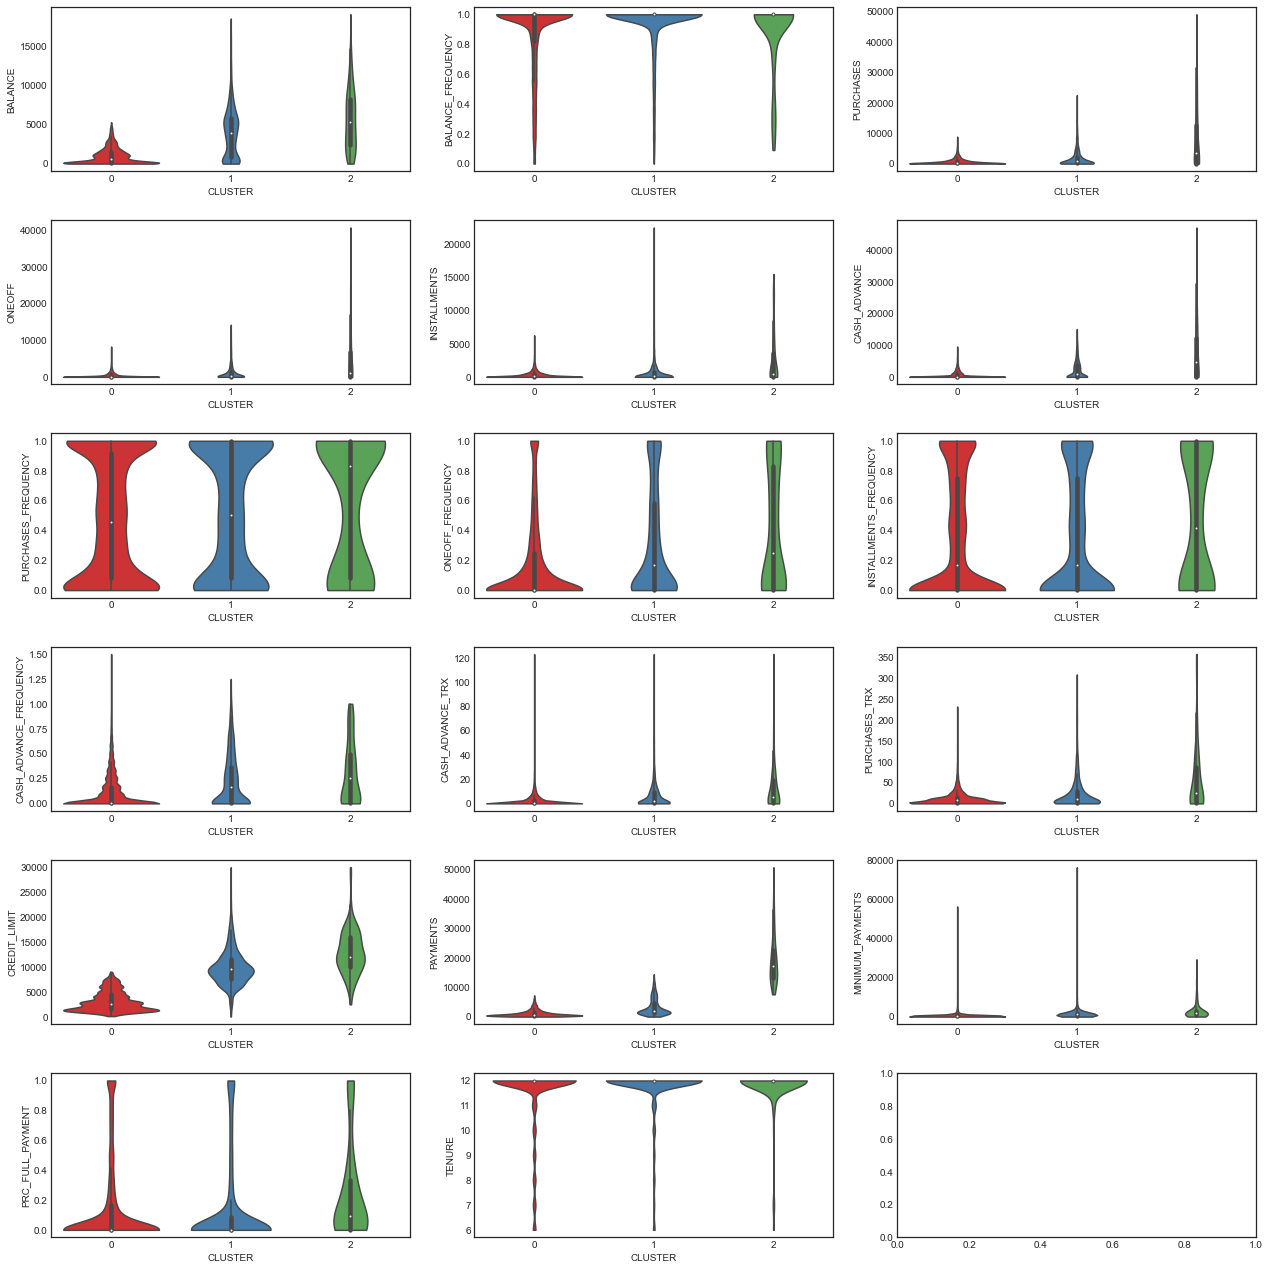

In [105]:
plot_violin(credit_card_cluster, 6, 3, 18, 18)

In [104]:
credit_card_cluster_0 = credit_card_cluster[credit_card_cluster['CLUSTER'] == 0]
credit_card_cluster_1 = credit_card_cluster[credit_card_cluster['CLUSTER'] == 1]
credit_card_cluster_2 = credit_card_cluster[credit_card_cluster['CLUSTER'] == 2]

Untuk feature yang masing-masing terpilih bisa dibuat range hasilnya. bisa 'exclude outlier` untuk analysisnya

# Recommendations
## Credit Card Product
### Silver
### Gold
### Platinum

## Question
- Bagaimana penentuan `CREDIT_LIMIT` untuk setiap kartu kredit? Apakah kita berikan rekomendasi range dari `CREDIT_LIMIT`? Sebagai contoh, pengguna tidak akan bisa memiliki `CREDIT_LIMIT` lebih dari \$5.000 untuk SILVER
- Rewards apa yang harus kita adakan untuk setiap kartu kredit?
    - Cash back pembelian di supermarket atau rumah makan => **SILVER**
    - Cash back pembelian produk di platform e-commerce (bergantung jenis dan harga produk yang dibeli) => **GENERAL**
    - Buy One Get One untuk produk tertentu, seperti minuman (Starbucks) atau tiket bioskop => **GENERAL**
    - Travel points and premium airport services => **PLATINUM**
    - Marketing campaign untuk masing-masing kartu berbeda dimana kartu **PLATINUM** lebih banyak mendapatkan penawaran yang menarik
- Annual fees bisa ditiadakan atau direduksi pada tahun pertama atau tahun tertentu untuk customer yang mencapai minimum transaksi tertentu pada tahun tersebut atau untuk customer kartu kredit **SILVER**. Tujuannya agar pengguna SILVER tidak terbebani dengan biaya tersebut dan masih mau memiliki dan menggunakan kartu kredit untuk pembelian produk atau pembayaran tagihan bulanan.

Notes: GENERAL bisa untuk semua jenis kartu kredit tetapi berbeda di minimum pembelian atau jumlah persentase cash back 

In [ ]:
Credit limit = low, medium, high
Balance = low, low-medium, low-high -> bayar credit card sesuai dengan yang dia spend sehingga tidak banyak balance tersisa
Payments = low, medium, high

## Feedback Mas Idris 30 Juni 2021
1. Apakah perlu dibuat violinplot untuk semua variabel setelah diperoleh hasil cluster?
2. Apakah perlu juga dibuat violinplot sewaktu pemilihan fitur? Jika memang dilakukan bisa dibandingkan hasil keduanya sehingga bisa dilihat perubahannya.

# Estimation for Reduce Cost

General credit card churn estimates for 25% -> https://www.statista.com/statistics/816735/customer-churn-rate-by-industry-us/

We must calculate our churn rate:
- Define active customer: we can check from `BALANCE_FREQUENCY` columns that has range 0.0-0.2 (misalkan)
- cari referensi customer segementation bisa kurangin berapa persen

In [41]:
credit_card_cluster[credit_card_cluster['BALANCE_FREQUENCY'] < 0.5]['CLUSTER'].value_counts()

NameError: name 'credit_card_cluster' is not defined